#RNA Block Operations

Application scenario: operations kit for combining decomposed components of RNA sequences

In [1]:
%matplotlib inline

In [2]:
def rfam_uri(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)
rfam_id = 'RF00005'

In [3]:
opts={'size':14, 'node_border':False, 'node_size':200, 'font_size':9, 'vertex_alpha':0.6}

from eden.util.display import draw_graph, serialize_graph
import itertools
def plot(graphs, num=1, opts=None):    
    graphs = itertools.islice(graphs,num)
    for graph in graphs: draw_graph(graph, **opts)

In [4]:
def pre_process(data):
    from eden.converter.fasta import fasta_to_sequence
    seqs = fasta_to_sequence(rfam_uri(rfam_id))
    
    from eden.converter.rna.rnafold import rnafold_to_eden
    graphs = rnafold_to_eden(seqs)

    from eden.modifier.graph import vertex_attributes
    from itertools import islice
    graphs = islice(vertex_attributes.colorize(graphs, output_attribute = 'level', labels = ['A','U','C','G']),1)

    return graphs

/home/kohvaeip/.local/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/kohvaeip/.local/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


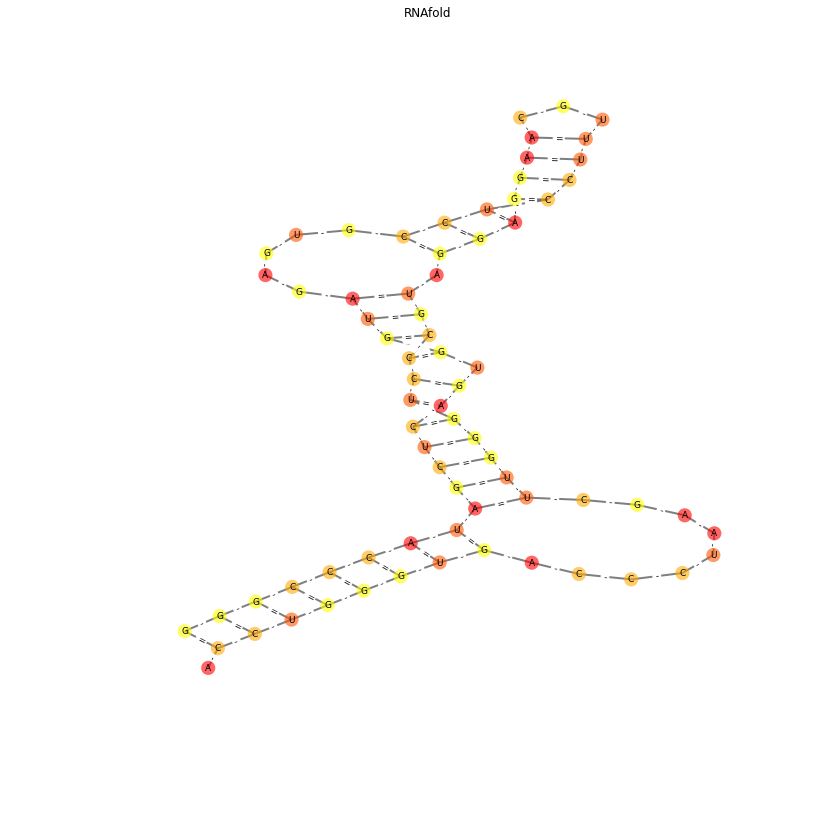

In [5]:
graphs = pre_process(rfam_uri(rfam_id))
my_opt=dict(opts)
my_opt.update({'vertex_color':'level', 'colormap':'autumn'})
plot(graphs,opts=my_opt)

In [6]:
import plant.RNAdecomposition as rnadc
reload(rnadc)

<module 'plant.RNAdecomposition' from '/home/kohvaeip/RLS/plant/RNAdecomposition.pyc'>

In [7]:
graphs = pre_process(rfam_uri(rfam_id))
for graph in graphs:
    dc_components, dc2 = rnadc.graph_decomposition(graph = graph)

In [8]:
def sub_graphs(dict):
    data = []
    for key in dict:
        data = data + dict[key]
    return data
        
data = sub_graphs(dc_components)

In [9]:
def pre_process(data):

    from eden.modifier.graph import vertex_attributes
    data = vertex_attributes.colorize(data, output_attribute = 'level', labels = ['A','U','C','G'])
    return data

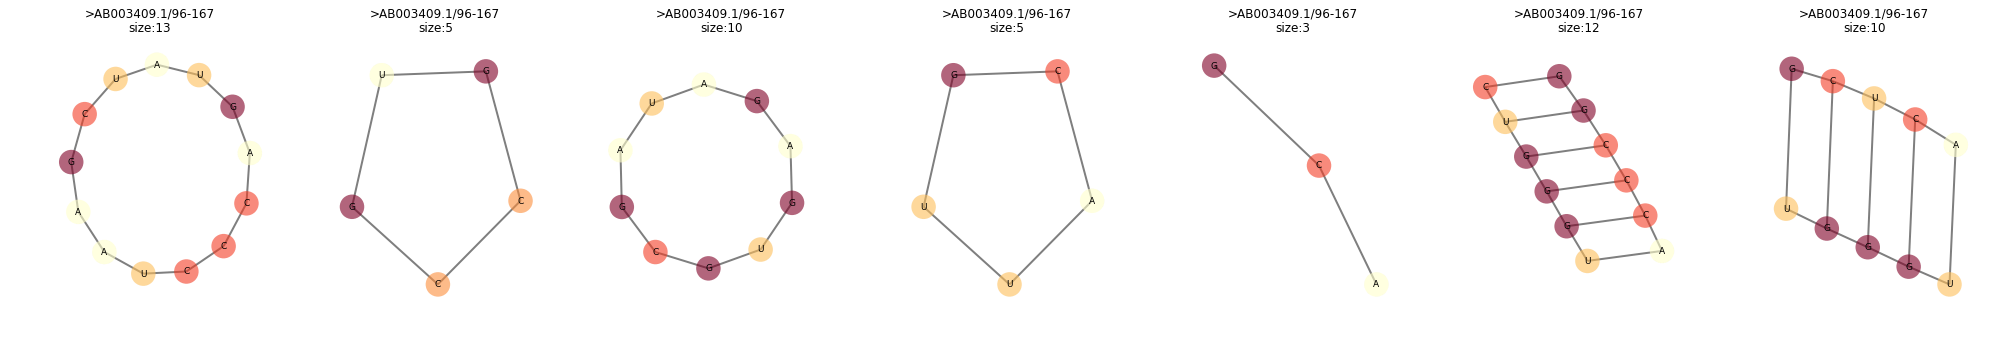

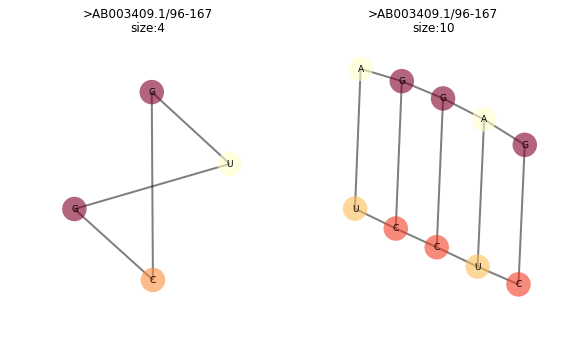

In [16]:
my_opt=dict(opts)
my_opt.update({'size':5, 'vertex_color':'level', 'colormap':'autumn'})
from eden.util.display import draw_graph_set
graphs = pre_process(data)
draw_graph_set(graphs,size=5, vertex_color="level", n_graphs_per_line=7)

#plot(graphs, num=None, opts=my_opt)

In [11]:
for item in data:
    print rnadc.scan_magnetic_ends(graph = item)

[(7, 63), (8, 53)]
[(16, 46), (47, 14)]
[(41, 25), (43, 19)]
[(35, 31)]
[(0, 70)]
[(64, 6), (1, 69)]
[(9, 52), (13, 48)]
[(17, 45), (18, 44)]
[(36, 30), (40, 26)]


# One-step component recombination

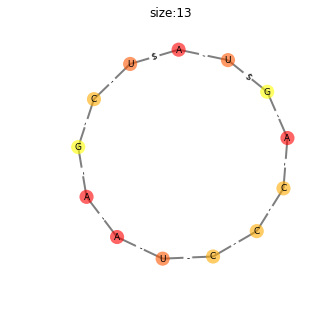

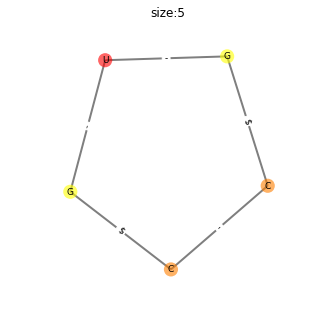

In [12]:
import networkx as nx

G = data[0]
H = data[1]

my_opt = dict(opts)
my_opt.update({'size':5, 'vertex_color':'level', 'colormap':'autumn'})

graphs = [G,H]
graphs = pre_process(graphs)
plot(graphs, num=None, opts=my_opt)

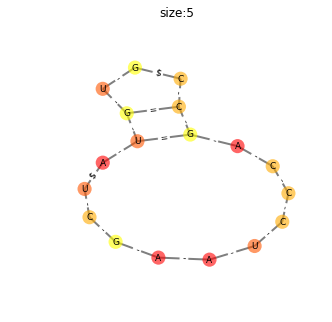

In [13]:
import networkx as nx
import plant.RNAdecomposition as rnadc
reload(rnadc)

"""
def add_block(block1 = None, block2 = None):
    graph = nx.disjoint_union(block1 , block2)
    component1 , component2 = list(nx.connected_component_subgraphs(graph))
    mg_end_list1 =  rnadc.scan_magnetic_ends(graph = component1)
    mg_end_list2 =  rnadc.scan_magnetic_ends(graph = component2)
    if len(mg_end_list1) > 0 and len(mg_end_list2) > 0 :
        mg_end1 = mg_end_list1[0]
        mg_end2 = mg_end_list2[0]
        x,y = mg_end1
        w,z = mg_end2
        graph.add_edge(x,w,type='backbone',label='-')
        graph.add_edge(y,z,type='backbone',label='-')
        rnadc.reset_break_points(graph = graph, pairs = [mg_end1,mg_end2])
    else:
        pass
        #exception
    return graph
"""
graphs = [rnadc.add_block(block1 = G, block2 = H)]
#add_block(block1 = G, block2 = H)
#graphs = [I]

my_opt=dict(opts)
my_opt.update({'size':5, 'vertex_color':'level', 'colormap':'autumn'})
graphs = pre_process(graphs)
plot(graphs, num=None, opts=my_opt)


In [14]:
rfam_id = 'RF00005'

def rfam_url(family_id):
    return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)

from eden.converter.fasta import fasta_to_sequence
from eden.converter.rna.rnafold import rnafold_to_eden
from eden.graph import Vectorizer
from eden.util import fit,estimate

iterable_pos = fasta_to_sequence( rfam_url(rfam_id) )

from itertools import tee
iterable_pos, iterable_pos_ = tee(iterable_pos)

from eden.modifier.seq import seq_to_seq,  shuffle_modifier
iterable_neg = seq_to_seq( iterable_pos_ , modifier=shuffle_modifier, times=3, order=2 )

#Positive sample graphs.
graphs_pos = rnafold_to_eden( iterable_pos )
#Negative sample graphs.
graphs_neg = rnafold_to_eden( iterable_neg )

vectorizer = Vectorizer( complexity = 2 )

In [15]:
%%time
estimator = fit(graphs_pos, graphs_neg, vectorizer, n_jobs=1, cv=3)

KeyboardInterrupt: 

In [ ]:
iterable = fasta_to_sequence( rfam_url(rfam_id) )
iterable = rnafold_to_eden( iterable )
iterable = vectorizer.annotate(iterable, estimator=estimator)

from itertools import islice

threshold = -1

iterable = islice(iterable, 2)

def reset_unimportant_nodes(iterable = None, threshold = None, label = None):
    for graph in iterable:
        for node, data in graph.nodes_iter(data=True):
            if float(data['importance']) < threshold:
                data['label'] = label
        yield graph
        
iterable = reset_unimportant_nodes(iterable = iterable, threshold = threshold, label = '.')

In [ ]:
def pre_process(data):

    from eden.modifier.graph import vertex_attributes
    data = vertex_attributes.colorize(data, output_attribute = 'level', labels = ['A','U','C','G','N'])
    return data

my_opt = dict(opts)
my_opt.update({'size':6, 'vertex_color':'level', 'colormap':'summer'})

iterable = pre_process(iterable)

plot(iterable, num = None, opts = my_opt)